## Introduction

This notebook contains code for implementing [H2o Auto-ML](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html) in Python for a classification problem. The task is to predict customer churn for a telecommunications company. The dataset used is from [Maven Analytics] (https://www.mavenanalytics.io/blog/maven-churn-challenge).

## Notebook Settings

In [392]:
# notebook settings
# Increase width of cells
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# set working directory
import os
curr_dir = os.getcwd()
os.chdir(curr_dir)

## Setup

In [393]:
# Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from mizani.formatters import *

# Options
pd.set_option("display.max.rows", 50)
pd.set_option("display.max.columns", 50)

### Load Data


In [394]:
# load data
df_churn_raw = pd.read_csv("../data/telecom_customer_churn.csv")
df_population_raw = pd.read_csv("../data/telecom_zipcode_population.csv")

df_churn_raw.shape, df_population_raw.shape

((7043, 38), (1671, 2))

In [395]:
# data inspection churn df
df_churn_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

In [396]:
# data inspection population df
df_population_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Zip Code    1671 non-null   int64
 1   Population  1671 non-null   int64
dtypes: int64(2)
memory usage: 26.2 KB


In [397]:
# format data
df_churn = df_churn_raw.rename(columns = lambda x: x.replace(" ", "_").lower())
df_population = df_population_raw.rename(columns = lambda x: x.replace(" ", "_").lower())

In [398]:
# view data
df_churn.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [399]:
# missing data percentage
df_churn.isnull().sum()/len(df_churn)

customer_id                          0.000000
gender                               0.000000
age                                  0.000000
married                              0.000000
number_of_dependents                 0.000000
city                                 0.000000
zip_code                             0.000000
latitude                             0.000000
longitude                            0.000000
number_of_referrals                  0.000000
tenure_in_months                     0.000000
offer                                0.000000
phone_service                        0.000000
avg_monthly_long_distance_charges    0.096834
multiple_lines                       0.096834
internet_service                     0.000000
internet_type                        0.216669
avg_monthly_gb_download              0.216669
online_security                      0.216669
online_backup                        0.216669
device_protection_plan               0.216669
premium_tech_support              

## Data Prep

In [400]:
# prepare data for analysis

# 1 - filter customer status for Stayed and Churned
# 2 - drop churn category and churn reason (these features are determined "after" a customer has churned)

df_churn = df_churn[df_churn["customer_status"].isin(["Stayed", "Churned"])]\
    .drop(["churn_category", "churn_reason"], axis = 1)

## Exploratory Data Analysis

In [401]:
# utilities
percent_format = percent_format()
comma_format = custom_format("{:,.0f}")

In [402]:
# numberic features
df_churn.select_dtypes(exclude="object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6589 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                6589 non-null   int64  
 1   number_of_dependents               6589 non-null   int64  
 2   zip_code                           6589 non-null   int64  
 3   latitude                           6589 non-null   float64
 4   longitude                          6589 non-null   float64
 5   number_of_referrals                6589 non-null   int64  
 6   tenure_in_months                   6589 non-null   int64  
 7   avg_monthly_long_distance_charges  5945 non-null   float64
 8   avg_monthly_gb_download            5245 non-null   float64
 9   monthly_charge                     6589 non-null   float64
 10  total_charges                      6589 non-null   float64
 11  total_refunds                      6589 non-null   float

In [403]:
# categoric features
df_churn.select_dtypes(include="object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6589 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   customer_id             6589 non-null   object
 1   gender                  6589 non-null   object
 2   married                 6589 non-null   object
 3   city                    6589 non-null   object
 4   offer                   6589 non-null   object
 5   phone_service           6589 non-null   object
 6   multiple_lines          5945 non-null   object
 7   internet_service        6589 non-null   object
 8   internet_type           5245 non-null   object
 9   online_security         5245 non-null   object
 10  online_backup           5245 non-null   object
 11  device_protection_plan  5245 non-null   object
 12  premium_tech_support    5245 non-null   object
 13  streaming_tv            5245 non-null   object
 14  streaming_movies        5245 non-null   object
 15  stre

### Univariate EDA

#### Proportion of Target

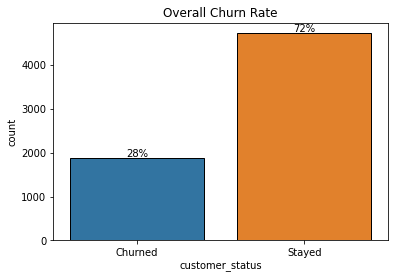

In [404]:
# overall churn rate
churn_rate = df_churn.groupby("customer_status").size().reset_index()\
    .rename(columns = {0: "count"})\
    .assign(percent = lambda x: round(x["count"]/sum(x["count"]), 2))

ax = sns.barplot(data=churn_rate, x="customer_status", y="count", edgecolor = "k")
ax.bar_label(ax.containers[0], labels=percent_format(churn_rate["percent"]));
ax.set_title("Overall Churn Rate");

#### Distribution of Numeric Features

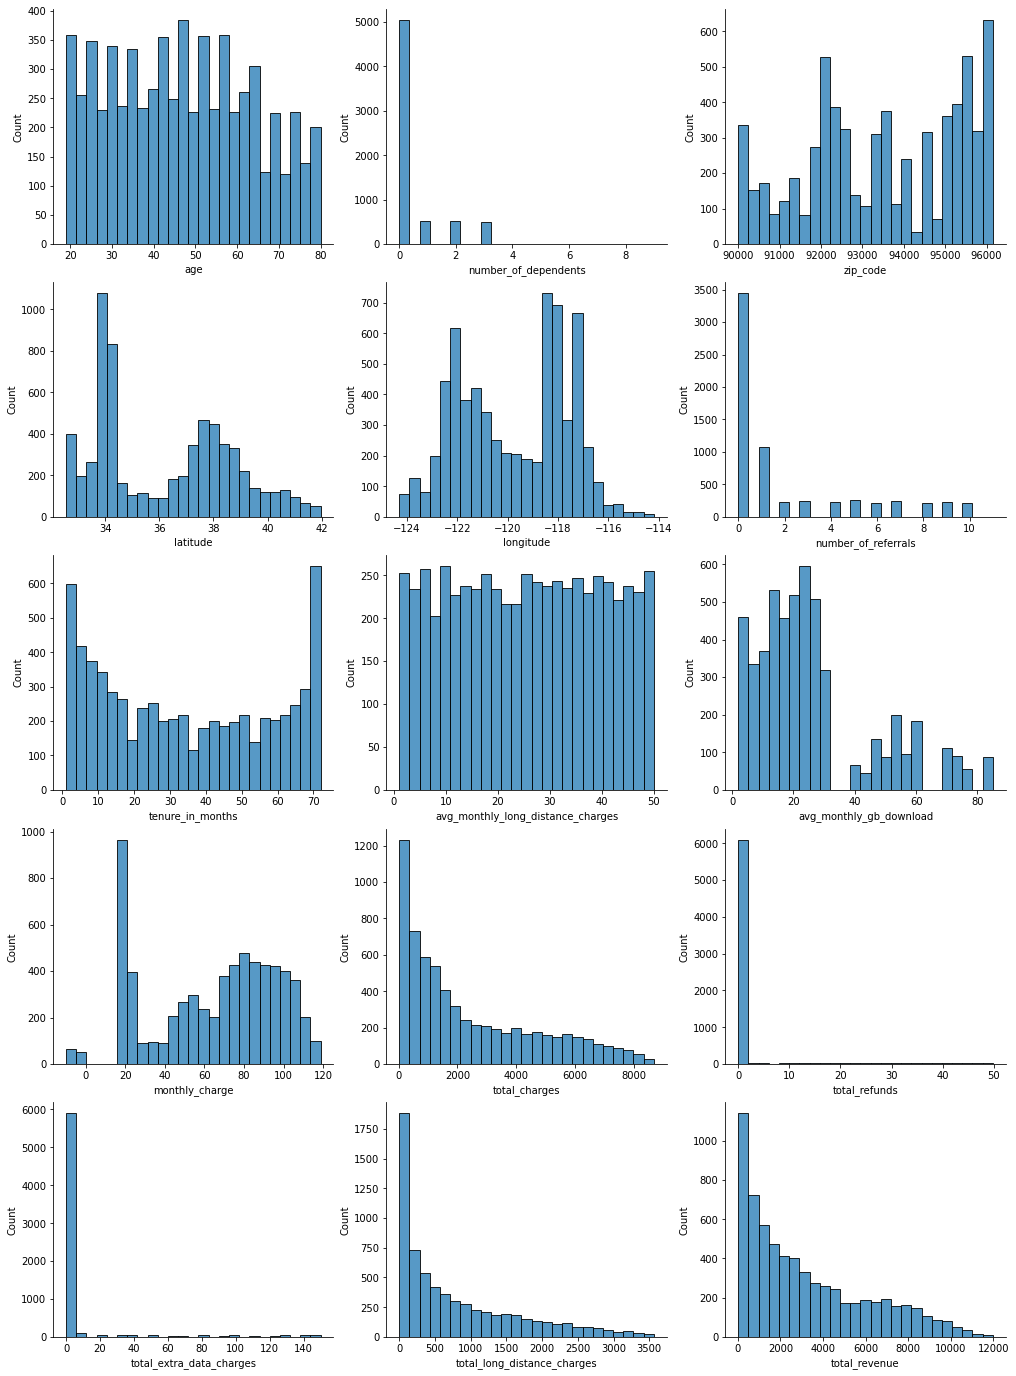

In [405]:
# distribution of numeric features
num_features = df_churn.select_dtypes(exclude='object').columns.tolist()

fig, axes = plt.subplots(5, 3, figsize=(14, 19), constrained_layout=True)

for feature, ax in zip(num_features, axes.ravel()):
    sns.histplot(x=feature, data=df_churn, ax=ax, bins=25)
    sns.despine()

### Distribution of Categorical Features

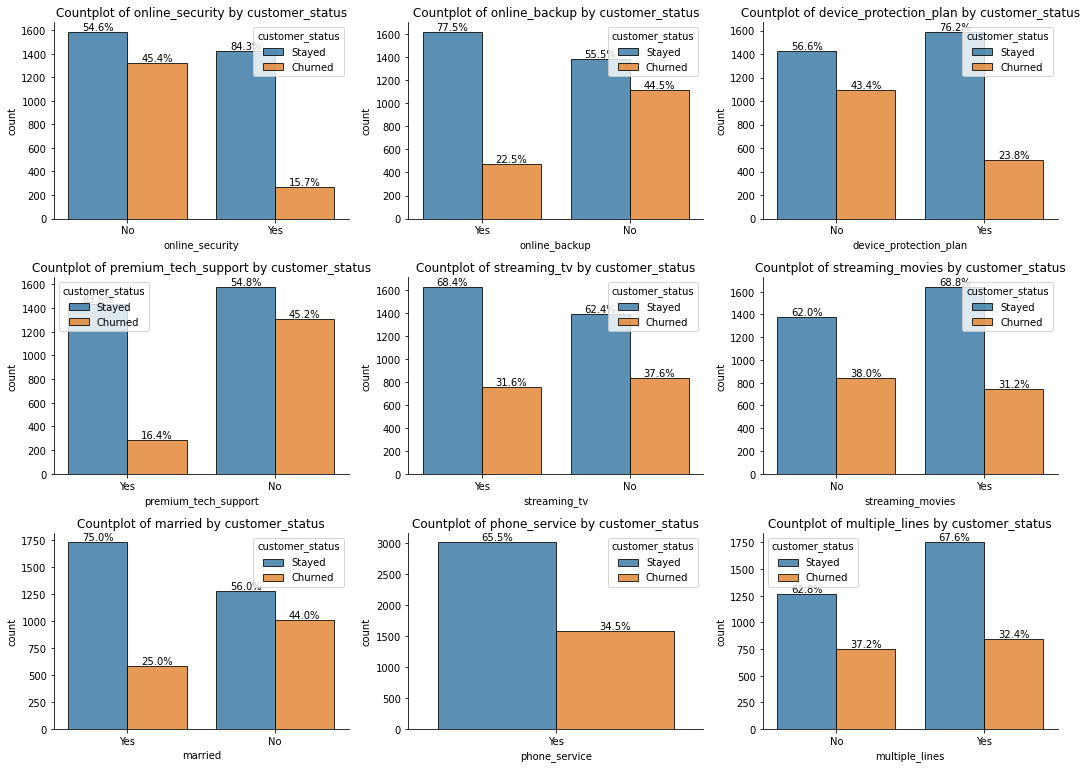

In [406]:
df_churn_dropna = df_churn.dropna()

features = ["online_security", "online_backup", "device_protection_plan", "premium_tech_support", "streaming_tv", "streaming_movies", "married", "phone_service",
           "multiple_lines"]
hue = "customer_status"
hue_type = df_churn_dropna[hue].dtype.type

fig, axs = plt.subplots(3, 3, figsize=(18, 13))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

# group ordering differs by dtype  
for feat, ax in zip(features, axs.ravel()):    
    col = df_churn_dropna[feat]
    if col.dtype == 'category':
        groups = col.cat.categories
    elif col.dtype == 'bool':
        groups = [False, True]
    else:
        groups = col.unique()
    
    # within-feature proportions
    proportions = df_churn_dropna.groupby(feat)[hue].value_counts(normalize=True)
    
    # countplots
    sns.countplot(x=feat, hue=hue, edgecolor='k', alpha=0.8, data=df_churn_dropna, ax=ax)
    ax.set_title(f'Countplot of {feat} by {hue}')
    sns.despine()
    
    # retrieve proportions by the container's label (hue) and group (feature)
    for c in ax.containers:
        labels = [f'{proportions.loc[g, c.get_label()]:.1%}' for g in groups]
        ax.bar_label(c, labels)       

In [413]:
# stacked bar plot function for categorical features
def stacked_bar_plot(data, feature, xtick_rotation=0):
    
    df_crosstab = pd.crosstab(index=data[feature], columns=data["customer_status"])
    
    df_crosstab.plot(kind = "bar", stacked=True, figsize=(10, 5), color=["#ff7f0e", "#1f77b4"], edgecolor="k", alpha=0.8);
    plt.title(f"customer_status by {feature}");
    plt.xticks(rotation=xtick_rotation)

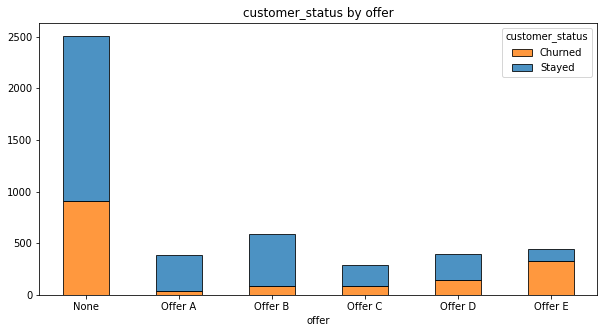

In [414]:
# customer status by offer
stacked_bar_plot(data = df_churn_dropna, feature = "offer")

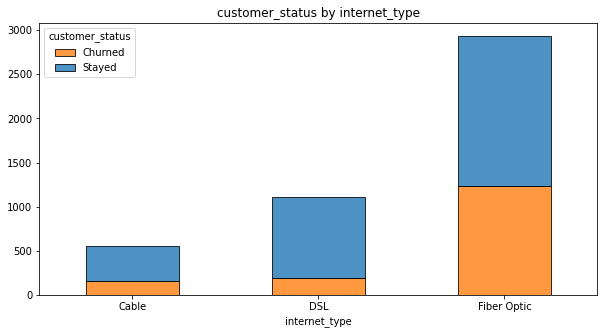

In [415]:
# customer status by internet type
stacked_bar_plot(data = df_churn_dropna, feature = "internet_type")

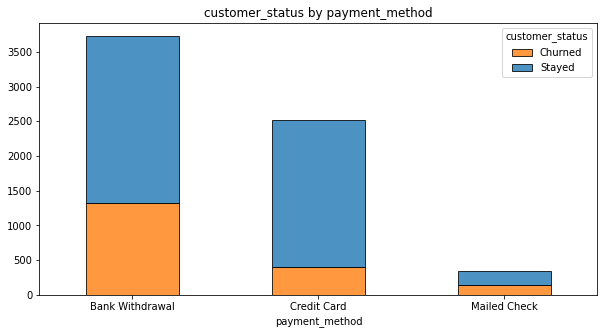

In [416]:
# customer status by payment method
stacked_bar_plot(data = df_churn, feature = "payment_method");

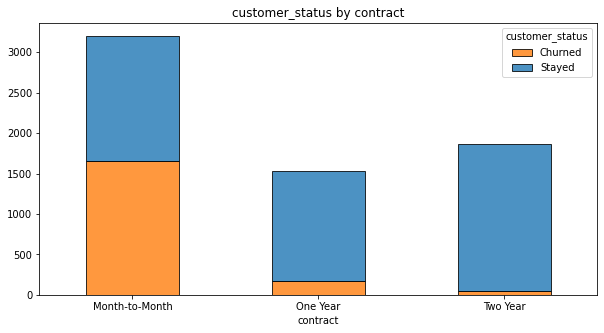

In [417]:
# customer status by contract
stacked_bar_plot(data = df_churn, feature = "contract")

### Multivariate EDA

#### Churn by Numeric Features

In [418]:
# churn vs numerical features
def churn_vs_num_features(data, feature):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 3.8), sharey=False)
    plt.subplots_adjust(wspace=0.4)
    
    #fig.suptitle(f'Distribution of ${feature}$')
    
    p1 = sns.histplot(data=data, x=feature, hue="customer_status", bins=35, multiple="stack", ax=axes[0])
    
    p2 = sns.boxplot(data=data, x=feature, y="customer_status", ax=axes[1]);
    p2.set(ylabel=None)

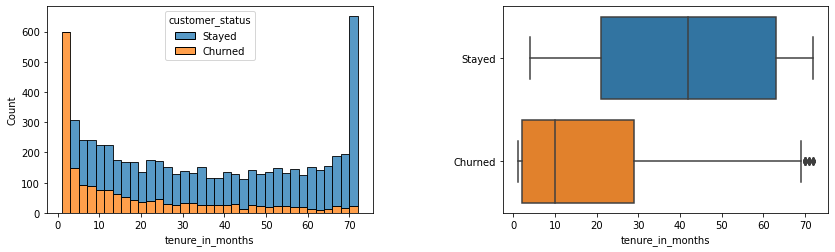

In [419]:
churn_vs_num_features(data=df_churn, feature="tenure_in_months")

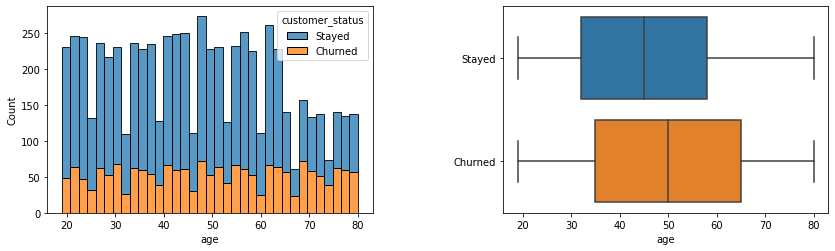

In [106]:
churn_vs_num_features(data=df_churn, feature="age")

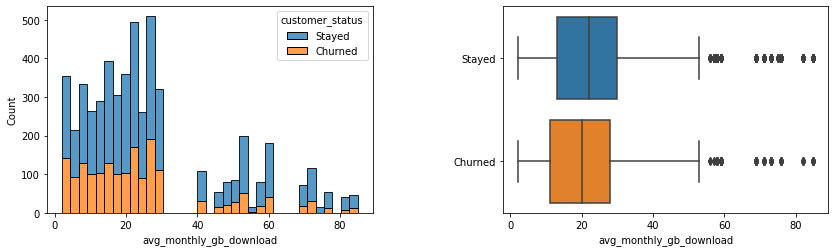

In [108]:
churn_vs_num_features(data=df_churn, feature="avg_monthly_gb_download")

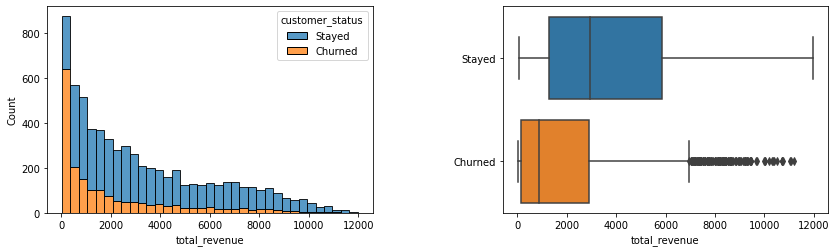

In [109]:
churn_vs_num_features(data=df_churn, feature="total_revenue")

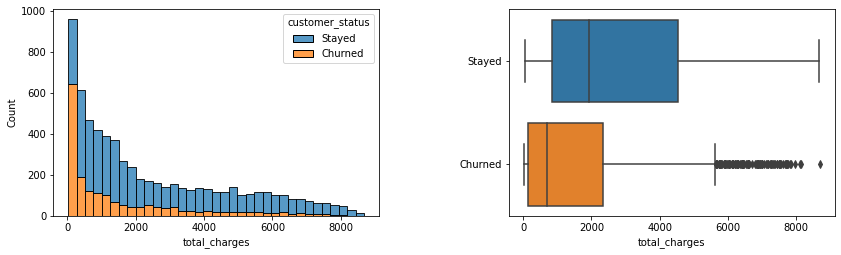

In [301]:
churn_vs_num_features(data=df_churn, feature="total_charges")

#### Pairplots

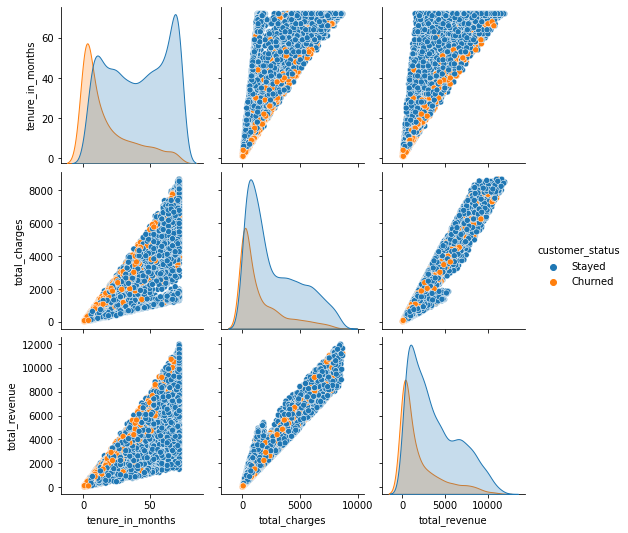

In [420]:
# pairplot of customer_status by tenure_in_months, total_charges & total_revenue
data = df_churn[["tenure_in_months", "total_charges", "total_revenue", "customer_status"]]
ax = sns.pairplot(data=data, hue="customer_status");

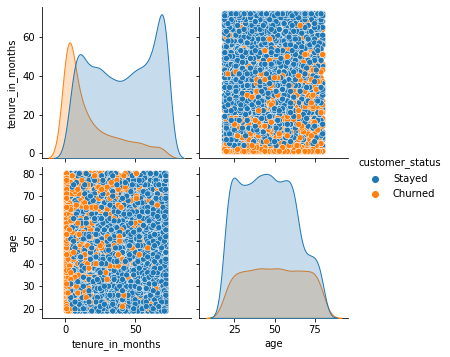

In [300]:
# pairplot of customer_status by age & tenure_in_months
data = df_churn[["tenure_in_months", "age", "customer_status"]]
sns.pairplot(data=data, hue="customer_status");

## Prep Data For Modeling

In [306]:
features_to_drop = ["customer_id", "city", "zip_code", "latitude", "longitude"]
df_model_ready = df_churn.drop(features_to_drop, axis=1)
df_model_ready.shape

(6589, 31)

## Modeling With H2o

#### H2o Setup

In [329]:
# imports
import h2o
from h2o.automl import H2OAutoML

In [309]:
# initialize h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.301-b09, mixed mode)
  Starting server from C:\Users\lokwudishu\Anaconda3\envs\hubspot\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\LOKWUD~1\AppData\Local\Temp\tmpjjmz85s0
  JVM stdout: C:\Users\LOKWUD~1\AppData\Local\Temp\tmpjjmz85s0\h2o_lokwudishu_started_from_python.out
  JVM stderr: C:\Users\LOKWUD~1\AppData\Local\Temp\tmpjjmz85s0\h2o_lokwudishu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,2 months and 24 days
H2O_cluster_name:,H2O_from_python_lokwudishu_30qsfb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.502 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


#### H2o Data Prep

In [319]:
# convert data to h2o frame
df_h2o = h2o.H2OFrame(df_model_ready)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [321]:
# set predictors and target
predictors = df_model_ready.drop("customer_status", axis=1).columns.tolist()
target = "customer_status"

In [325]:
# split data into train and testing sets
df_h2o_train, df_h2o_test = df_h2o.split_frame(ratios = [0.8], seed = 123)
df_h2o_train.shape, df_h2o_test.shape

((5279, 31), (1310, 31))

In [326]:
# change response to factors
df_h2o_train["customer_status"] = df_h2o_train["customer_status"].asfactor()
df_h2o_test["customer_status"] = df_h2o_test["customer_status"].asfactor()

### H2o Auto-ML

In [330]:
# run h2o auto-ml
h2o_automl = H2OAutoML(max_models=20, nfolds=5, seed=123)
h2o_automl.train(x=predictors, y=target, training_frame=df_h2o_train)

AutoML progress: |
19:09:58.972: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220707_190958

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04543337679017717
RMSE: 0.21315106565573902
LogLoss: 0.15482005106364763
Null degrees of freedom: 5278
Residual degrees of freedom: 5268
Null deviance: 6299.433355377097
Residual deviance: 1634.5900991299918
AIC: 1656.5900991299918
AUC: 0.9872228752148698
AUCPR: 0.9949946268144694
Gini: 0.9744457504297397

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5637450559934275: 


,,Churned,Stayed,Error,Rate
0,Churned,1345.0,154.0,0.1027,(154.0/1499.0)
1,Stayed,142.0,3638.0,0.0376,(142.0/3780.0)
2,Total,1487.0,3792.0,0.0561,(296.0/5279.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.563745,0.960909,208.0
1,max f2,0.425903,0.973266,252.0
2,max f0point5,0.733537,0.971020,148.0
3,max accuracy,0.563745,0.943929,208.0
4,max precision,0.999507,1.000000,0.0
5,max recall,0.140596,1.000000,341.0
6,max specificity,0.999507,1.000000,0.0
7,max absolute_mcc,0.597391,0.862369,197.0
8,max min_per_class_accuracy,0.642567,0.936624,181.0
9,max mean_per_class_accuracy,0.681079,0.940948,167.0



Gains/Lift Table: Avg response rate: 71.60 %, avg score: 72.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010040,0.999652,1.396561,1.396561,1.000000,0.999691,1.000000,0.999691,0.014021,0.014021,39.656085,39.656085,0.014021
1,2,0.020080,0.999590,1.396561,1.396561,1.000000,0.999615,1.000000,0.999653,0.014021,0.028042,39.656085,39.656085,0.028042
2,3,0.030119,0.999541,1.396561,1.396561,1.000000,0.999564,1.000000,0.999623,0.014021,0.042063,39.656085,39.656085,0.042063
3,4,0.040159,0.999509,1.396561,1.396561,1.000000,0.999523,1.000000,0.999598,0.014021,0.056085,39.656085,39.656085,0.056085
4,5,0.050009,0.999485,1.396561,1.396561,1.000000,0.999498,1.000000,0.999578,0.013757,0.069841,39.656085,39.656085,0.069841
5,6,0.100019,0.999202,1.396561,1.396561,1.000000,0.999345,1.000000,0.999462,0.069841,0.139683,39.656085,39.656085,0.139683
6,7,0.150028,0.998782,1.396561,1.396561,1.000000,0.999018,1.000000,0.999314,0.069841,0.209524,39.656085,39.656085,0.209524
7,8,0.200038,0.998051,1.396561,1.396561,1.000000,0.998433,1.000000,0.999094,0.069841,0.279365,39.656085,39.656085,0.279365
8,9,0.300057,0.994972,1.396561,1.396561,1.000000,0.996756,1.000000,0.998314,0.139683,0.419048,39.656085,39.656085,0.419048
9,10,0.400076,0.983311,1.396561,1.396561,1.000000,0.990398,1.000000,0.996335,0.139683,0.558730,39.656085,39.656085,0.558730




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08922569461320752
RMSE: 0.2987067033282104
LogLoss: 0.28224141525921603
Null degrees of freedom: 5278
Residual degrees of freedom: 5268
Null deviance: 6305.740433942189
Residual deviance: 2979.904862306803
AIC: 3001.904862306803
AUC: 0.9345059845893735
AUCPR: 0.971470327145096
Gini: 0.869011969178747

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38723843059602575: 


,,Churned,Stayed,Error,Rate
0,Churned,980.0,519.0,0.3462,(519.0/1499.0)
1,Stayed,149.0,3631.0,0.0394,(149.0/3780.0)
2,Total,1129.0,4150.0,0.1265,(668.0/5279.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.387238,0.915763,265.0
1,max f2,0.244138,0.955183,311.0
2,max f0point5,0.753023,0.915366,145.0
3,max accuracy,0.445214,0.875166,249.0
4,max precision,0.999157,1.000000,0.0
5,max recall,0.074300,1.000000,366.0
6,max specificity,0.999157,1.000000,0.0
7,max absolute_mcc,0.445214,0.681585,249.0
8,max min_per_class_accuracy,0.724679,0.847231,156.0
9,max mean_per_class_accuracy,0.719501,0.848409,158.0



Gains/Lift Table: Avg response rate: 71.60 %, avg score: 71.60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010040,0.999087,1.396561,1.396561,1.000000,0.999331,1.000000,0.999331,0.014021,0.014021,39.656085,39.656085,0.014021
1,2,0.020080,0.998711,1.396561,1.396561,1.000000,0.998891,1.000000,0.999111,0.014021,0.028042,39.656085,39.656085,0.028042
2,3,0.030119,0.998372,1.370211,1.387777,0.981132,0.998527,0.993711,0.998916,0.013757,0.041799,37.021064,38.777745,0.041132
3,4,0.040159,0.998077,1.396561,1.389973,1.000000,0.998206,0.995283,0.998739,0.014021,0.055820,39.656085,38.997330,0.055153
4,5,0.050009,0.997664,1.396561,1.391271,1.000000,0.997866,0.996212,0.998567,0.013757,0.069577,39.656085,39.127084,0.068910
5,6,0.100019,0.995345,1.396561,1.393916,1.000000,0.996573,0.998106,0.997570,0.069841,0.139418,39.656085,39.391584,0.138751
6,7,0.150028,0.991647,1.391271,1.393034,0.996212,0.993557,0.997475,0.996233,0.069577,0.208995,39.127084,39.303418,0.207660
7,8,0.200038,0.987055,1.396561,1.393916,1.000000,0.989467,0.998106,0.994541,0.069841,0.278836,39.656085,39.391584,0.277502
8,9,0.300057,0.975578,1.375401,1.387744,0.984848,0.981860,0.993687,0.990314,0.137566,0.416402,37.540083,38.774417,0.409731
9,10,0.400076,0.950114,1.364821,1.382013,0.977273,0.964618,0.989583,0.983890,0.136508,0.552910,36.482083,38.201334,0.538234




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.879363,0.010764,0.893870,0.887232,0.870968,0.868992,0.875752
1,auc,0.934467,0.006813,0.938917,0.935348,0.923842,0.932745,0.941483
2,err,0.120637,0.010764,0.106130,0.112768,0.129032,0.131008,0.124248
3,err_count,127.200000,9.884331,116.000000,121.000000,136.000000,139.000000,124.000000
4,f0point5,0.894665,0.014486,0.910398,0.908982,0.881403,0.880353,0.892188
5,f1,0.919575,0.007986,0.929095,0.925994,0.918269,0.909564,0.914952
6,f2,0.946055,0.007783,0.948577,0.943655,0.958354,0.940781,0.938908
7,lift_top_group,1.398266,0.045890,1.383544,1.354798,1.361757,1.461432,1.429799
8,logloss,0.282195,0.012707,0.270233,0.271569,0.293913,0.297466,0.277796
9,max_per_class_error,0.336841,0.065746,0.283828,0.306050,0.450000,0.334328,0.310000



See the whole table with table.as_data_frame()


In [332]:
# view h2o auto-ml leaderboard
h2o_leader_board = h2o_automl.leaderboard
h2o_leader_board.head(rows=h2o_leader_board.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20220707_190958,0.934506,0.282241,0.97147,0.192824,0.298707,0.0892257
StackedEnsemble_BestOfFamily_1_AutoML_1_20220707_190958,0.933431,0.283756,0.970869,0.184583,0.299331,0.089599
GBM_1_AutoML_1_20220707_190958,0.933126,0.285255,0.971088,0.185929,0.299715,0.089829
GBM_3_AutoML_1_20220707_190958,0.933001,0.288966,0.970649,0.199967,0.302312,0.0913925
GBM_5_AutoML_1_20220707_190958,0.932766,0.287158,0.970866,0.190616,0.300213,0.090128
GBM_grid_1_AutoML_1_20220707_190958_model_2,0.931838,0.287032,0.970543,0.195021,0.300856,0.0905144
GBM_grid_1_AutoML_1_20220707_190958_model_1,0.931673,0.290225,0.970413,0.191323,0.30225,0.0913548
GBM_2_AutoML_1_20220707_190958,0.931467,0.289575,0.970299,0.200186,0.301268,0.0907622
GBM_grid_1_AutoML_1_20220707_190958_model_3,0.929429,0.29476,0.969451,0.202043,0.30428,0.0925864
GBM_4_AutoML_1_20220707_190958,0.929309,0.297452,0.969374,0.207852,0.305661,0.0934284


### Saving H2o Models

In [336]:
# save best models

# auto-ml leader
h2o.save_model( 
    model = h2o_automl.leader,
    path  = "../artifacts/",
    force = True
)

# best gbm model
h2o.save_model( 
    model = h2o_automl.get_best_model(algorithm="GBM"),
    path  = "../artifacts/",
    force = True
)

# best deep learning model
h2o.save_model( 
    model = h2o_automl.get_best_model(algorithm="DeepLearning"),
    path  = "../artifacts/",
    force = True
)

'C:\\Users\\lokwudishu\\Desktop\\Projects\\Python\\telecom_customer_churn\\artifacts\\DeepLearning_grid_2_AutoML_1_20220707_190958_model_1'

## Evaluating H2o Model Performance

### Performance Metrics

In [346]:
# get best gbm
h2o_automl_gbm = h2o_automl.get_best_model(algorithm="GBM")

In [349]:
# retrieve performance 
h2o_automl_gbm_performance = h2o_automl_gbm.model_performance(df_h2o_test)
h2o_automl_gbm_performance


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08432686090205752
RMSE: 0.2903908760654465
LogLoss: 0.2725535372557703
Mean Per-Class Error: 0.17938470385278896
AUC: 0.9384933870040253
AUCPR: 0.9724538952409084
Gini: 0.8769867740080506

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42568613254666265: 


,,Churned,Stayed,Error,Rate
0,Churned,253.0,117.0,0.3162,(117.0/370.0)
1,Stayed,40.0,900.0,0.0426,(40.0/940.0)
2,Total,293.0,1017.0,0.1198,(157.0/1310.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.425686,0.919775,271.0
1,max f2,0.170271,0.956273,343.0
2,max f0point5,0.742856,0.928137,163.0
3,max accuracy,0.626742,0.880916,205.0
4,max precision,0.997814,1.000000,0.0
5,max recall,0.060121,1.000000,372.0
6,max specificity,0.997814,1.000000,0.0
7,max absolute_mcc,0.626742,0.713749,205.0
8,max min_per_class_accuracy,0.695866,0.864865,177.0
9,max mean_per_class_accuracy,0.742856,0.867754,163.0



Gains/Lift Table: Avg response rate: 71.76 %, avg score: 71.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010687,0.996822,1.393617,1.393617,1.000000,0.997303,1.000000,0.997303,0.014894,0.014894,39.361702,39.361702,0.014894
1,2,0.020611,0.996190,1.393617,1.393617,1.000000,0.996451,1.000000,0.996893,0.013830,0.028723,39.361702,39.361702,0.028723
2,3,0.030534,0.995361,1.393617,1.393617,1.000000,0.995795,1.000000,0.996536,0.013830,0.042553,39.361702,39.361702,0.042553
3,4,0.040458,0.994474,1.393617,1.393617,1.000000,0.994973,1.000000,0.996153,0.013830,0.056383,39.361702,39.361702,0.056383
4,5,0.050382,0.993795,1.393617,1.393617,1.000000,0.994210,1.000000,0.995770,0.013830,0.070213,39.361702,39.361702,0.070213
5,6,0.100000,0.990692,1.393617,1.393617,1.000000,0.992321,1.000000,0.994059,0.069149,0.139362,39.361702,39.361702,0.139362
6,7,0.150382,0.987316,1.372502,1.386543,0.984848,0.989122,0.994924,0.992405,0.069149,0.208511,37.250161,38.654282,0.205808
7,8,0.200000,0.983199,1.393617,1.388298,1.000000,0.985800,0.996183,0.990766,0.069149,0.277660,39.361702,38.829787,0.274957
8,9,0.300000,0.971569,1.351064,1.375887,0.969466,0.977902,0.987277,0.986478,0.135106,0.412766,35.106383,37.588652,0.399252
9,10,0.400000,0.948458,1.361702,1.372340,0.977099,0.962248,0.984733,0.980421,0.136170,0.548936,36.170213,37.234043,0.527315


### ROC Curve

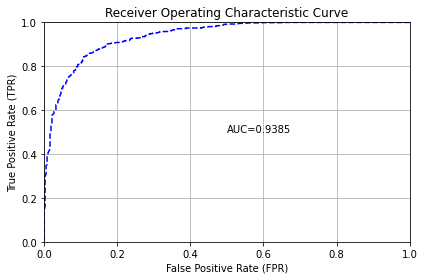

In [357]:
# roc curve
h2o_automl_gbm_performance.plot(type="roc");

### AUCPR Curve

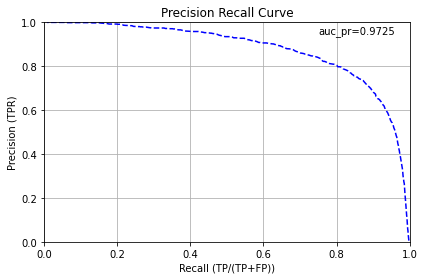

In [365]:
h2o_automl_gbm_performance.plot(type="pr");

## Predictions

In [358]:
h2o_automl_gbm_pred_df = h2o_automl_gbm.predict(df_h2o_test)
h2o_automl_gbm_pred_df

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,Churned,Stayed
Stayed,0.0274805,0.97252
Stayed,0.00633841,0.993662
Stayed,0.0169734,0.983027
Stayed,0.00420852,0.995791
Stayed,0.0217344,0.978266
Stayed,0.0852916,0.914708
Stayed,0.0109541,0.989046
Stayed,0.157203,0.842797
Stayed,0.112875,0.887125
Stayed,0.0330817,0.966918


In [422]:
# merge predictions with test data
h2o_automl_gbm_pred_df2 = df_h2o_test["customer_status"].cbind(h2o_automl_gbm_pred_df)
h2o_automl_gbm_pred_df2

customer_status,predict,Churned,Stayed
Stayed,Stayed,0.0274805,0.97252
Stayed,Stayed,0.00633841,0.993662
Stayed,Stayed,0.0169734,0.983027
Stayed,Stayed,0.00420852,0.995791
Stayed,Stayed,0.0217344,0.978266
Stayed,Stayed,0.0852916,0.914708
Stayed,Stayed,0.0109541,0.989046
Stayed,Stayed,0.157203,0.842797
Stayed,Stayed,0.112875,0.887125
Stayed,Stayed,0.0330817,0.966918


## Model Explainability

#### Variable Importance


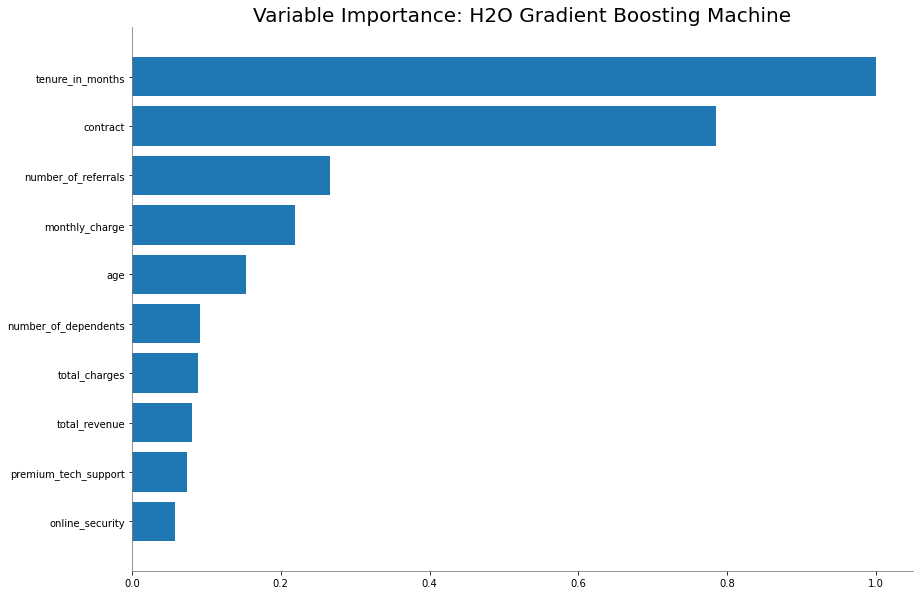

<Figure size 432x288 with 0 Axes>

In [353]:
# auto-ml vip
h2o_automl_gbm.varimp_plot();

#### Single Row Prediction Explanation

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

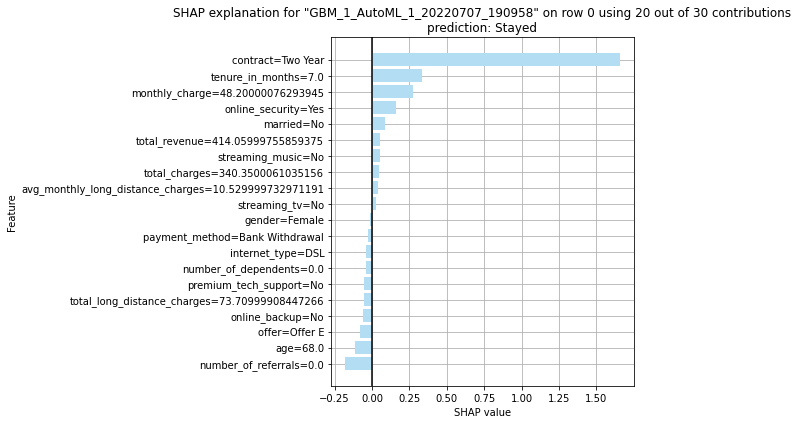

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

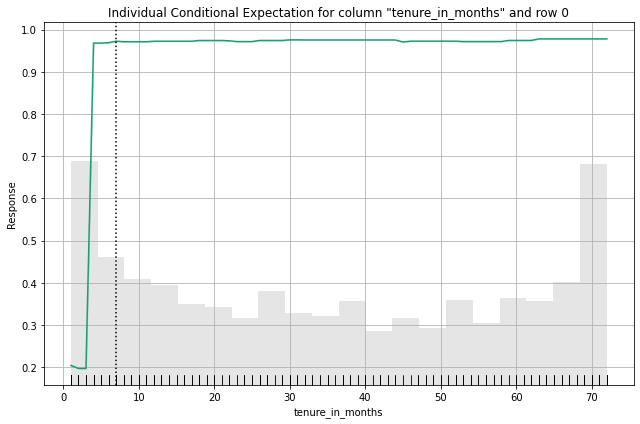

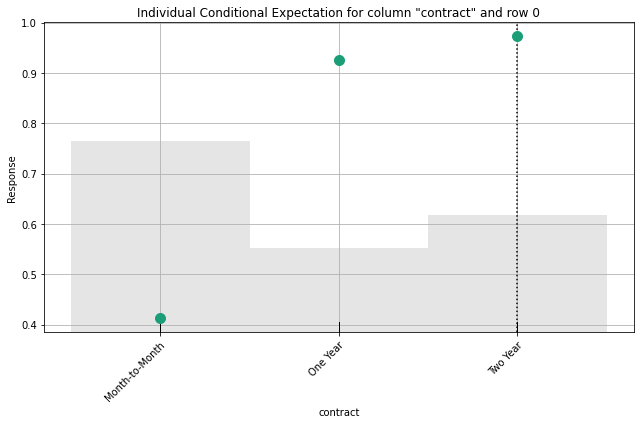

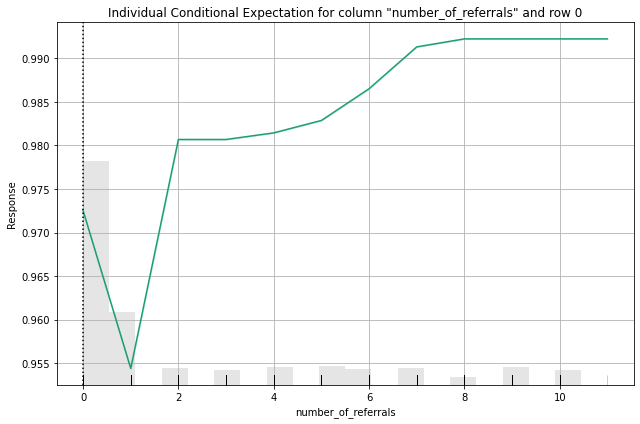

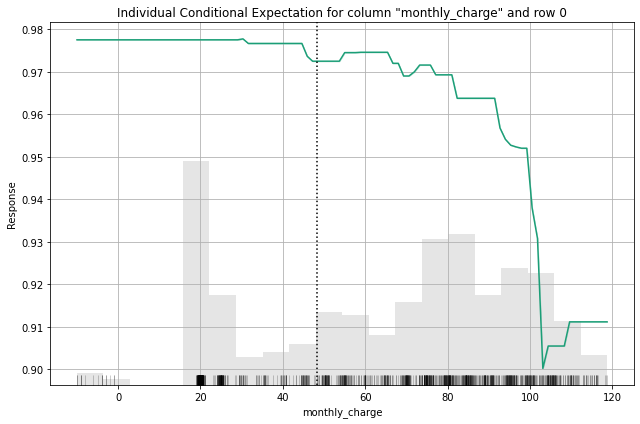

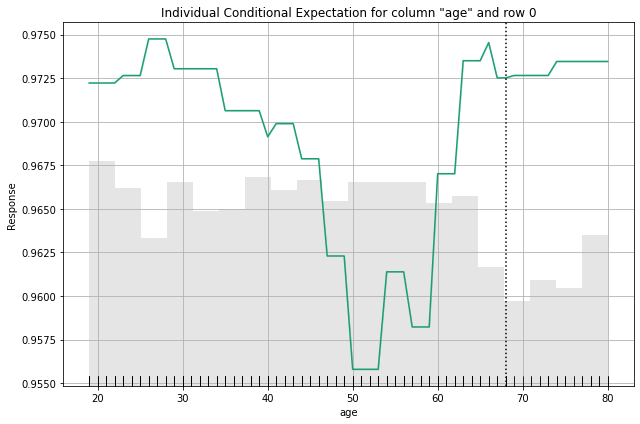

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

In [370]:
# single row explainer
h2o_automl_gbm.explain_row(df_h2o_test, row_index=0, figsize=(9, 6))

#### SHAP Summary

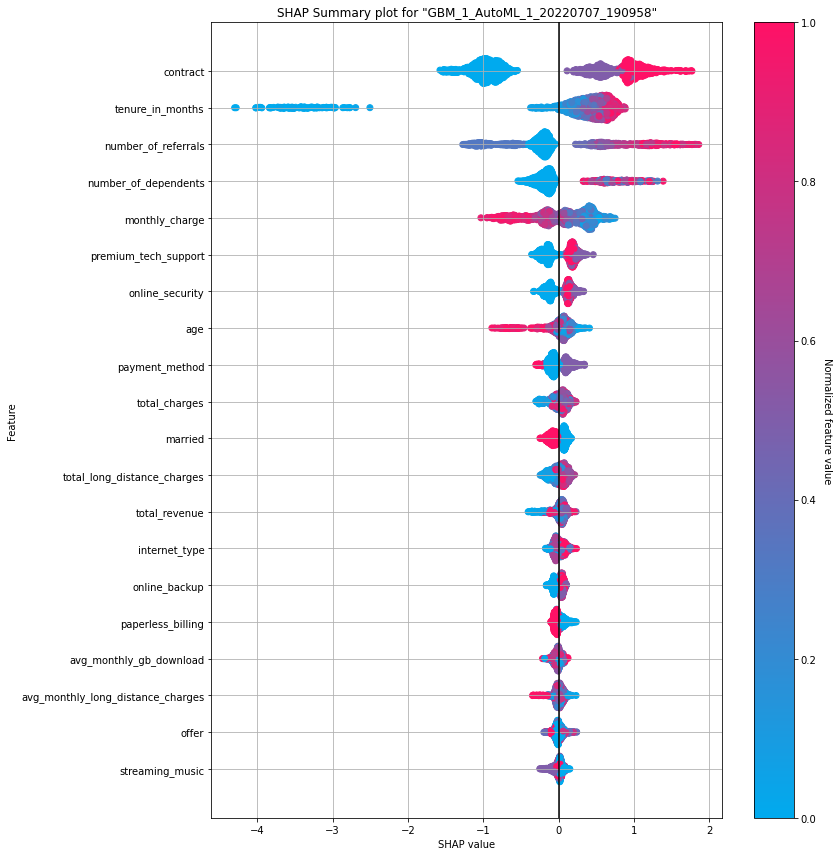

In [367]:
# shap summary
h2o_automl_gbm.shap_summary_plot(df_h2o_test, );